<a href="https://colab.research.google.com/github/EnsarIshakoglu/NLP/blob/demo-eric-supervised/NLP_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Source: https://keras.io/examples/nlp/multi_label_classification/#introduction
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from ast import literal_eval

# Tensorflow
import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa

# Keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, Input
from keras.layers import Dense, Conv1D, SeparableConv1D, BatchNormalization, MaxPool1D, Dropout, Flatten, Embedding

# SKlearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE

# Data processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Stackapi to fetch stackoverflow api
!pip install stackapi
from stackapi import StackAPI

     |████████████████████████████████| 1.1 MB 4.8 MB/s 
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
  Created wheel for stackapi: filename=StackAPI-0.2.0-py3-none-any.whl size=5856 sha256=4ca4a9ea55b5fbac2af6b609da0054c08e4c21e95704516a71a0eddbde99bdb7
  Stored in directory: /root/.cache/pip/wheels/ec/db/60/df42a65853e3581c26a2fbb2012a228cb8e267369a3b9ca44d
Successfully built stackapi


### Mount colab drive to google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fetch data

In [3]:
# Get the data from stackoverflow sorted by votes
def fetch_data():
  if not exists('/content/NLP-question-data'):
    !git clone https://github.com/EnsarIshakoglu/NLP-question-data.git
  
  data = pd.read_csv('/content/NLP-question-data/questions.csv')
  return data

## Remove useless data

In [ ]:
# def clean_data(df):  
#   df = df[['tags', 'body']]

#   # Strip html tags with regex:
#   df['body'] = df['body'].str.replace(r'<[^<>]*>', '', regex=True)

#   # Get first tag for multi-class classification
#   row_count = df.shape[0]

#   # for i in range(row_count):
#   #   df['tags'].iloc[i] = df['tags'].iloc[i][0]
  
#   return df

### Create folder and file from df, unmout drive after

In [5]:
from os.path import exists

!mkdir stackoverflow

if not exists('/content/stackoverflow/questions.csv'):
  data = fetch_data()
  # df = clean_data(data)
  # data.to_csv('/content/stackoverflow/questions.csv')
  print("Fetched data from stackoverflow, removed the useless data and saved it in stackoverflow/questions.csv")

drive.flush_and_unmount()

mkdir: cannot create directory ‘stackoverflow’: File exists
Fetched data from stackoverflow, removed the useless data and saved it in stackoverflow/questions.csv


### Load file from drive

In [6]:
raw_df = pd.read_csv('/content/NLP-question-data/questions.csv')

raw_df.head()

,Unnamed: 0,tags,owner,is_answered,view_count,protected_date,accepted_answer_id,answer_count,score,last_activity_date,creation_date,last_edit_date,question_id,content_license,link,title,body,community_owned_date,locked_date,closed_date,closed_reason,migrated_from
0,0,"['java', 'c++', 'performance', 'cpu-architectu...","{'reputation': 469918, 'user_id': 87234, 'user...",True,1662469,1.399067e+09,11227902.0,29,26031,1636434375,1340805096,1.634760e+09,11227809,CC BY-SA 4.0,https://stackoverflow.com/questions/11227809/w...,Why is processing a sorted array faster than p...,<p>Here is a piece of C++ code that shows some...,NaN,NaN,NaN,NaN,NaN
1,1,"['git', 'version-control', 'git-commit', 'undo']","{'reputation': 47989, 'user_id': 89904, 'user_...",True,10254767,1.370840e+09,927386.0,100,23542,1637838948,1243620554,1.625030e+09,927358,CC BY-SA 4.0,https://stackoverflow.com/questions/927358/how...,How do I undo the most recent local commits in...,<p>I accidentally <strong>committed the wrong ...,1.363429e+09,NaN,NaN,NaN,NaN
2,2,"['git', 'version-control', 'git-branch', 'git-...","{'reputation': 416782, 'user_id': 95592, 'user...",True,9430056,1.358718e+09,2003515.0,41,18667,1638336685,1262653935,1.633560e+09,2003505,CC BY-SA 4.0,https://stackoverflow.com/questions/2003505/ho...,How do I delete a Git branch locally and remot...,<p>I want to delete a branch both locally and ...,NaN,NaN,NaN,NaN,NaN
3,3,"['git', 'version-control', 'git-pull', 'git-fe...","{'reputation': 264138, 'user_id': 6068, 'user_...",True,3071149,1.362879e+09,292359.0,38,12908,1636728187,1226742669,1.606493e+09,292357,CC BY-SA 4.0,https://stackoverflow.com/questions/292357/wha...,What is the difference between &#39;git pull&#...,<p>What are the differences between <code>git ...,NaN,NaN,NaN,NaN,NaN
4,4,"['python', 'iterator', 'generator', 'yield', '...","{'reputation': 131777, 'user_id': 18300, 'user...",True,2731894,1.360547e+09,231855.0,43,11664,1636440019,1224800471,1.633986e+09,231767,CC BY-SA 4.0,https://stackoverflow.com/questions/231767/wha...,What does the &quot;yield&quot; keyword do?,<p>What is the use of the <code>yield</code> k...,NaN,NaN,NaN,NaN,NaN


In [7]:
from ast import literal_eval

df = raw_df[['tags', 'body']]


# Get first tag for multi-class classification
row_count = df.shape[0]

for i in range(row_count):
  array = literal_eval(df['tags'].iloc[i])
  df['tags'].iloc[i] = array[0]

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,tags,body
0,java,<p>Here is a piece of C++ code that shows some...
1,git,<p>I accidentally <strong>committed the wrong ...
2,git,<p>I want to delete a branch both locally and ...
3,git,<p>What are the differences between <code>git ...
4,python,<p>What is the use of the <code>yield</code> k...


In [8]:
print(f"There are {len(df['body'].unique())} rows in the dataset.")

There are 3900 rows in the dataset.


In [9]:
df = df[~df['body'].duplicated()]
print(f"There are {len(df)} rows in the deduplicated dataset.")

There are 3900 rows in the deduplicated dataset.


In [12]:
# Remove <pre> tags
df_filtered = df
df_filtered['body'] = df_filtered['body'].replace('<pre.*?</pre>','', regex=True)
df_filtered['body'] = df_filtered['body'].replace('<code.*?</code>','', regex=True)
df_filtered.iloc[0]['body']

'<p>Here is a piece of C++ code that shows some very peculiar behavior. For some strange reason, sorting the data (<em>before</em> the timed region) miraculously makes the loop almost six times faster.</p>\n<pre class="lang-cpp prettyprint-override"><code>#include &lt;algorithm&gt;\n#include &lt;ctime&gt;\n#include &lt;iostream&gt;\n\nint main()\n{\n    // Generate data\n    const unsigned arraySize = 32768;\n    int data[arraySize];\n\n    for (unsigned c = 0; c &lt; arraySize; ++c)\n        data[c] = std::rand() % 256;\n\n    // !!! With this, the next loop runs faster.\n    std::sort(data, data + arraySize);\n\n    // Test\n    clock_t start = clock();\n    long long sum = 0;\n    for (unsigned i = 0; i &lt; 100000; ++i)\n    {\n        for (unsigned c = 0; c &lt; arraySize; ++c)\n        {   // Primary loop\n            if (data[c] &gt;= 128)\n                sum += data[c];\n        }\n    }\n\n    double elapsedTime = static_cast&lt;double&gt;(clock()-start) / CLOCKS_PER_SEC;\n\n

In [13]:
# Remove html tags
df_filtered['body'] = df_filtered['body'].str.replace(r'<[^<>]*>', '', regex=True)

In [14]:
# Remove punctuation
df_filtered['body'] = df_filtered['body'].replace('[^\w\s]','', regex=True)
df_filtered['body'] = df_filtered['body'].replace(r'\s+|\\n', ' ', regex=True) 

In [16]:
# There are a lot of terms with occurrence below 40.
threshold = 5

print(sum(df['tags'].value_counts() < threshold))

# How many unique terms?
print(df['tags'].nunique())

161
223


In [17]:
# Filtering the rare terms because there is not enough data to train properly with.
df_filtered = df.groupby("tags").filter(lambda x: len(x) > threshold)
df_filtered.shape

(3644, 2)

In [18]:
# View example of text
for i in range(5):
  print(df_filtered.iloc[i]['body'])
  print('\n')

Here is a piece of C code that shows some very peculiar behavior For some strange reason sorting the data before the timed region miraculously makes the loop almost six times faster include ltalgorithmgt include ltctimegt include ltiostreamgt int main Generate data const unsigned arraySize 32768 int dataarraySize for unsigned c 0 c lt arraySize c datac stdrand 256 With this the next loop runs faster stdsortdata data arraySize Test clock_t start clock long long sum 0 for unsigned i 0 i lt 100000 i for unsigned c 0 c lt arraySize c Primary loop if datac gt 128 sum datac double elapsedTime static_castltdoublegtclockstart CLOCKS_PER_SEC stdcout ltlt elapsedTime ltlt n stdcout ltlt quotsum quot ltlt sum ltlt n Without the code runs in 1154 seconds With the sorted data the code runs in 193 seconds Sorting itself takes more time than this one pass over the array so its not actually worth doing if we needed to calculate this for an unknown array Initially I thought this might be just a languag

In [19]:
# Source: https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe

stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df_filtered['body'] = df_filtered['body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_filtered.head()

,tags,body
0,java,Here piece C code shows peculiar behavior For ...
1,git,I accidentally committed wrong files Git didnt...
2,git,I want delete branch locally remotely Failed A...
3,git,What differences
4,python,What use keyword Python What For example Im tr...


In [20]:
# Source: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Lemmatize words
lemmatizer = WordNetLemmatizer()
df_filtered['body'] = df_filtered['body'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in x.split()]))
df_filtered.head()

,tags,body
0,java,Here piece C code show peculiar behavior For s...
1,git,I accidentally commit wrong file Git didnt pus...
2,git,I want delete branch locally remotely Failed A...
3,git,What difference
4,python,What use keyword Python What For example Im tr...


In [21]:
# Check class imbalance:
print(df_filtered.groupby(df_filtered['tags']).size())

tags
.net                   16
algorithm              21
android               146
android-studio          7
angular                17
angularjs              14
arrays                  7
asp.net                 7
bash                   85
batch-file              8
c                      31
c#                    222
c++                   123
css                    77
database                7
docker                 35
eclipse                 8
git                   398
github                 12
haskell                 6
html                  132
http                   16
ios                    57
java                  295
javascript            601
jquery                 43
json                   14
language-agnostic      14
linux                  62
macos                  17
mongodb                10
mysql                  48
node.js                58
objective-c            11
oop                    12
php                    86
postgresql             17
python                531
r      

## Prepare data

In [22]:
df_filtered['label'] = pd.factorize(df_filtered['tags'])[0]
df_filtered.head()

,tags,body,label
0,java,Here piece C code show peculiar behavior For s...,0
1,git,I accidentally commit wrong file Git didnt pus...,1
2,git,I want delete branch locally remotely Failed A...,1
3,git,What difference,1
4,python,What use keyword Python What For example Im tr...,2


In [23]:
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(df_filtered['body'])
vectorizer.transform(df_filtered['body']).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [24]:
# Use stratified splits because of class imbalance
X = df_filtered['body']
y = df_filtered['label']

# Initial train and test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=132)

# Splitting the test set further into validation and new test sets.
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=23)

print(f"Number of rows in training set: {len(X_train)}")
print(f"Number of rows in validation set: {len(X_val)}")
print(f"Number of rows in test set: {len(X_test)}")

Number of rows in training set: 2915
Number of rows in validation set: 365
Number of rows in test set: 364


In [25]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_val = vectorizer.transform(X_val)

In [26]:
# Dataset preview
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (2915, 21734)
X_test shape: (364, 21734)
X_val shape: (365, 21734)
y_train shape: (2915,)


In [27]:
y_train.shape

(2915,)

## Create model

In [28]:
# Amount of columns in data:
input_dim = X_train.shape[1]

# Amount of unique labels:
output_dim = y_train.nunique()

print(f'Input dim: {input_dim}')
print(f'Output dim: {output_dim}')

Input dim: 21734
Output dim: 59


In [29]:
# Reshape labels
label_encoder = LabelEncoder()
y_train = np.array(label_encoder.fit_transform(y_train))
y_val = np.array(label_encoder.fit_transform(y_val))
y_test = np.array(label_encoder.fit_transform(y_test))

y_train = tf.one_hot(y_train, depth=output_dim)
y_val = tf.one_hot(y_val, depth=output_dim)
y_test = tf.one_hot(y_test, depth=output_dim)

In [30]:
# First define baseline model. Then use it in Keras Classifier for the training
def baseline_model():
    # Create model here
    model = Sequential()
    model.add(Dense(128, input_dim = input_dim, activation = 'relu')) # Rectified Linear Unit Activation Function
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))

    model.add(Dense(output_dim, activation = 'softmax')) # Softmax for multi-class classification
    # Compile model here
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

## Evaluate model

In [31]:
model = baseline_model()

model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2782080   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 59)                1947      
                                                                 
Total params: 2,794,363
Trainable params: 2,794,363
Non-trainable params: 0
_________________________________________________________________


In [32]:
# For Keras, convert dataframe to array values (Inbuilt requirement of Keras)
X = X_train
y = y_train

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


23/23 [==============================] - 3s 56ms/step - loss: 0.5854 - categorical_accuracy: 0.0034 - val_loss: 0.4186 - val_categorical_accuracy: 0.0000e+00
Epoch 2/15
23/23 [==============================] - 1s 47ms/step - loss: 0.2555 - categorical_accuracy: 0.0223 - val_loss: 0.1449 - val_categorical_accuracy: 0.1178
Epoch 3/15
23/23 [==============================] - 1s 46ms/step - loss: 0.1137 - categorical_accuracy: 0.1828 - val_loss: 0.1076 - val_categorical_accuracy: 0.2411
Epoch 4/15
23/23 [==============================] - 1s 47ms/step - loss: 0.0871 - categorical_accuracy: 0.3527 - val_loss: 0.0962 - val_categorical_accuracy: 0.2877
Epoch 5/15
23/23 [==============================] - 1s 43ms/step - loss: 0.0717 - categorical_accuracy: 0.4206 - val_loss: 0.0871 - val_categorical_accuracy: 0.3342
Epoch 6/15
23/23 [==============================] - 1s 48ms/step - loss: 0.0604 - categorical_accuracy: 0.4655 - val_loss: 0.0802 - val_categorical_accuracy: 0.3589
Epoch 7/15
23/23 

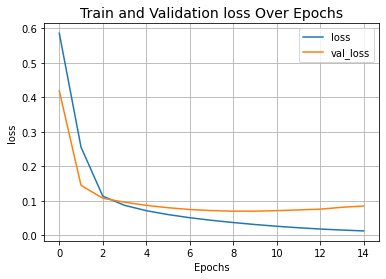

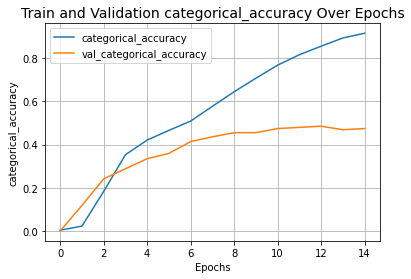

In [33]:
history = model.fit(X, y, validation_data=[X_val, y_val], batch_size = 128, epochs = 15, verbose = 1)

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [ ]:
_, categorical_acc = model.evaluate(X_test, y_test)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

11/11 [==============================] - 0s 3ms/step - loss: 0.1710 - categorical_accuracy: 0.7198
Categorical accuracy on the test set: 71.98%.
